In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
# read in data with fewest columns and least intensive data types possible
parcel_data=pd.read_csv('data/join_scag_to_parcels_left_2019.csv',
                        usecols=['APN','geometry'],
                        dtype={'APN':'float64'})
parcel_data.head()

,APN,geometry
0,933260003.0,POLYGON ((6783290.9227205515 1627339.245801280...
1,933190003.0,"POLYGON ((6782457.131636369 1627327.825767822,..."
2,933200001.0,POLYGON ((6783360.4120451175 1628192.010515577...
3,933180027.0,POLYGON ((6782203.810073653 1629150.3784866517...
4,933180028.0,"POLYGON ((6782031.88729954 1630184.5857774946,..."


In [3]:
# transform this into a geodataframe
from shapely import wkt
parcel_data['geometry']=parcel_data.geometry.apply(wkt.loads)
parcel_data=gpd.GeoDataFrame(parcel_data,crs=2229)

In [4]:
# replace polygon geometry with centroid
parcel_data['centroid']=parcel_data.centroid
parcel_data.set_geometry('centroid',inplace=True)
parcel_data.drop(columns=['geometry'],inplace=True)

In [5]:
# read in census data & keep just a unique identifier and the geometry
census_2009=gpd.read_file("data/census_2009.gpkg")
census_2009=census_2009[['GEO_ID','geometry']]
census_2009.to_crs(crs=2229,inplace=True)

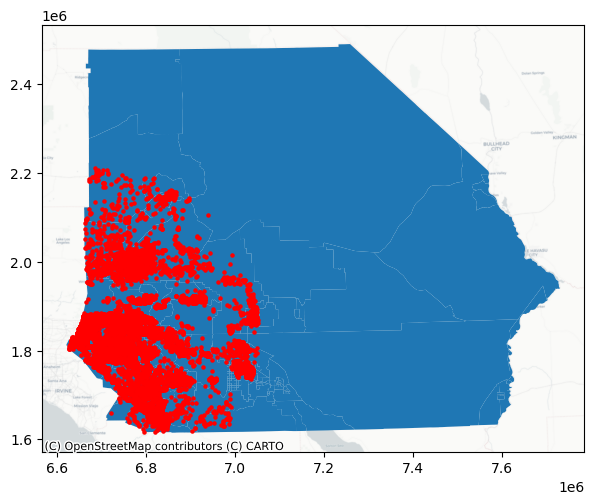

In [6]:
# first check that these are in the same general area and will probably spatially join?
fig, ax = plt.subplots(figsize=(7,7))
census_2009.plot(ax=ax)
parcel_data.sample(frac=0.01).plot(ax=ax,markersize=5,color='red')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=2229)

In [7]:
# Join census tract GEO_ID that intersects each APN
parcel_data=gpd.sjoin(parcel_data,census_2009,how='left', predicate='intersects')
parcel_data.drop(columns=['index_right'],inplace=True)

In [8]:
parcel_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1367392 entries, 0 to 1367391
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype   
---  ------    --------------    -----   
 0   APN       1367392 non-null  float64 
 1   centroid  1367392 non-null  geometry
 2   GEO_ID    1367326 non-null  object  
dtypes: float64(1), geometry(1), object(1)
memory usage: 41.7+ MB


In [9]:
parcel_data.APN.is_unique

True

<Axes: >

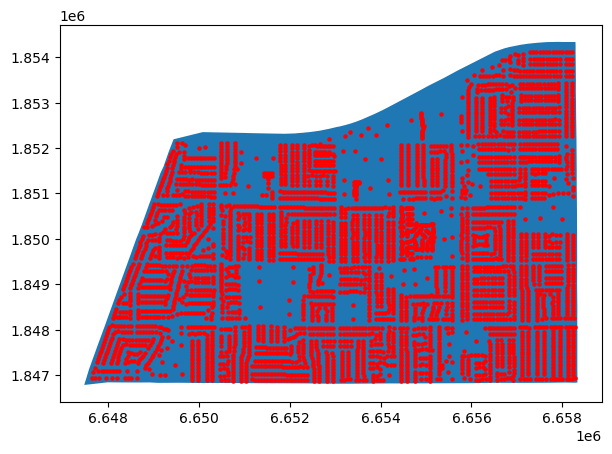

In [10]:
# test to see that this spatial join worked!
fig, ax = plt.subplots(figsize=(7,7))
census_2009[census_2009.GEO_ID=='06071000202'].plot(ax=ax)
parcel_data[parcel_data.GEO_ID=='06071000202'].plot(ax=ax,markersize=5,color='red')

In [11]:
crosswalk=parcel_data[['APN','GEO_ID']]
crosswalk

,APN,GEO_ID
0,933260003.0,06065043215
1,933190003.0,06065043215
2,933200001.0,06065043215
3,933180027.0,06065043224
4,933180028.0,06065043224
...,...,...
1367387,42622103.0,06071011900
1367388,42602122.0,06071011900
1367389,42620101.0,06071011900
1367390,42620202.0,06071011900


Now that we have our crosswalk we can do our join

In [12]:
# read in assessor-scag data
parcel_data=pd.read_csv('data/join_scag_to_parcels_left_2019.csv')

# data clean-up
# use lambda functions to denote whether warehouse had been built on each parcel by 2010 and by 2020 (fixing error in previous version)
parcel_data['warehouse_2010']=parcel_data.year.apply(lambda x: 1 if x<2010 else 0)
parcel_data['warehouse_2020']=parcel_data.year.apply(lambda x: 1 if x<2020 else 0)
parcel_data['built_2010s']=parcel_data.year.apply(lambda x: 1 if (2010 <= x < 2020) else 0)

# replace county names w/ dummies
dummies=pd.get_dummies(parcel_data.COUNTY, prefix='county')
parcel_data = parcel_data.join(dummies)

# copy dataset and delete/rename variables as needed
parcel_data.drop(columns=['warehouse_2020'],inplace=True)
parcel_data.rename(columns={'warehouse_2010':'warehouse_start','built_2010s':'buit_within_decade'},inplace=True)
parcel_data.head()

C:\Users\cpugh\AppData\Local\Temp\ipykernel_1736\2527098270.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  parcel_data=pd.read_csv('data/join_scag_to_parcels_left_2019.csv')


,APN,LAND_VALUE,distances,building_class,year,acres,sqft,num_warehouses,warehouse_start,buit_within_decade,...,Specific Plan,"Transportation, Communications, and Utilities",Under Construction,Undevelopable,Unknown,Vacant,Water,dollars_per_acre,county_Riverside,county_San Bernardino
0,933260003.0,48418.0,38449.033944,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2406.435207,1,0
1,933190003.0,210496.0,39355.337470,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10667.570219,1,0
2,933200001.0,347975.0,39133.409768,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17690.981870,1,0
3,933180027.0,88468.0,39830.303362,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9505.916138,1,0
4,933180028.0,334555.0,38830.371787,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16032.116147,1,0


In [13]:
#turning everything into float16 to save memory unless they're columns that need precision 
col_precise=['APN','LAND_VALUE','distances','dollars_per_acre','lat','lon','ACRES','IL_RATIO']
other_cols=[col for col in parcel_data.columns if col not in col_precise]

for col in other_cols:
    if parcel_data[col].dtype == 'float64': # skip the string column (srprec)
        parcel_data[col] = parcel_data[col].astype('float16')
        
#converting from int64 to int8
for col in other_cols:
    if parcel_data[col].dtype == 'int64': # skip the string column (srprec)
        parcel_data[col] = parcel_data[col].astype('int8')
        
parcel_data.head()

,APN,LAND_VALUE,distances,building_class,year,acres,sqft,num_warehouses,warehouse_start,buit_within_decade,...,Specific Plan,"Transportation, Communications, and Utilities",Under Construction,Undevelopable,Unknown,Vacant,Water,dollars_per_acre,county_Riverside,county_San Bernardino
0,933260003.0,48418.0,38449.033944,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2406.435207,1,0
1,933190003.0,210496.0,39355.337470,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10667.570219,1,0
2,933200001.0,347975.0,39133.409768,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17690.981870,1,0
3,933180027.0,88468.0,39830.303362,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9505.916138,1,0
4,933180028.0,334555.0,38830.371787,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16032.116147,1,0


In [14]:
#read in 2009 census data
census09 = gpd.read_file('data/census_2009.gpkg')
census09.head()

,GEO_ID,Median HH Income,state_x,county_x,tract_x,Total Pop,NAME,Percent White alone,Percent Black or African American alone,Percent American Indian and Alaska Native alone,...,tract_y_y,Percent Employee of private company workers,Percent Self-employed in own incorporated business workers,Percent Private not-for-profit wage and salary workers,Percent Local government workers,Percent State government workers,Percent Federal government workers,Percent Self-employed in own not incorporated business workers,Percent Unpaid family workers,geometry
0,06065043223,71775,06,065,043223,9277,"Census Tract 432.23, Riverside County, California",72.534224,2.953541,3.859006,...,043223,65.221675,3.078818,3.128079,10.197044,4.778325,1.305419,12.290640,0.000000,"POLYGON ((-117.18689 33.52935, -117.18701 33.5..."
1,06065043224,108708,06,065,043224,12791,"Census Tract 432.24, Riverside County, California",88.507544,1.852865,0.508170,...,043224,53.841787,10.844058,3.179410,13.872067,3.766086,1.703255,12.187737,0.605602,"POLYGON ((-117.21090 33.53000, -117.21100 33.5..."
2,06065043225,69173,06,065,043225,8749,"Census Tract 432.25, Riverside County, California",69.127900,4.069036,0.000000,...,043225,70.837563,2.436548,2.817259,13.172589,2.918782,1.700508,6.116751,0.000000,"POLYGON ((-117.25698 33.58463, -117.25736 33.5..."
3,06065043304,67813,06,065,043304,6088,"Census Tract 433.04, Riverside County, California",83.475690,0.344941,0.558476,...,043304,55.109344,4.970179,6.322068,12.365805,3.459245,1.232604,16.540755,0.000000,"POLYGON ((-116.89206 33.73303, -116.89157 33.7..."
4,06065043305,53998,06,065,043305,8872,"Census Tract 433.05, Riverside County, California",72.576646,5.094680,1.048242,...,043305,67.755102,1.102041,5.877551,13.591837,4.571429,4.285714,2.816327,0.000000,"POLYGON ((-116.97126 33.68992, -116.97125 33.6..."


In [15]:
# Join the GEO_ID into the parcel data
parcel_data.set_index('APN',inplace=True)
crosswalk.set_index('APN',inplace=True)
parcel_data=parcel_data.join(crosswalk,how='left')
parcel_data.head()

,LAND_VALUE,distances,building_class,year,acres,sqft,num_warehouses,warehouse_start,buit_within_decade,lon,...,"Transportation, Communications, and Utilities",Under Construction,Undevelopable,Unknown,Vacant,Water,dollars_per_acre,county_Riverside,county_San Bernardino,GEO_ID
APN,,,,,,,,,,,,,,,,,,,,,
933260003.0,48418.0,38449.033944,NaN,NaN,NaN,NaN,0.0,0,0,-117.275300,...,0.0,0.0,0.0,0.0,0.0,0.0,2406.435207,1,0,06065043215
933190003.0,210496.0,39355.337470,NaN,NaN,NaN,NaN,0.0,0,0,-117.276927,...,0.0,0.0,0.0,0.0,1.0,0.0,10667.570219,1,0,06065043215
933200001.0,347975.0,39133.409768,NaN,NaN,NaN,NaN,0.0,0,0,-117.275362,...,0.0,0.0,0.0,0.0,1.0,0.0,17690.981870,1,0,06065043215
933180027.0,88468.0,39830.303362,NaN,NaN,NaN,NaN,0.0,0,0,-117.277299,...,0.0,0.0,0.0,0.0,1.0,0.0,9505.916138,1,0,06065043224
933180028.0,334555.0,38830.371787,NaN,NaN,NaN,NaN,0.0,0,0,-117.275263,...,0.0,0.0,0.0,0.0,0.0,0.0,16032.116147,1,0,06065043224


In [16]:
# Now join the census data into the parcel data based on GEO_ID
parcel_data.reset_index(inplace=True)
parcel_data.set_index('GEO_ID',inplace=True)
census09.set_index('GEO_ID',inplace=True)
parcel_data=parcel_data.join(census09,how='left',rsuffix='_census')
parcel_data.head()

,APN,LAND_VALUE,distances,building_class,year,acres,sqft,num_warehouses,warehouse_start,buit_within_decade,...,tract_y_y,Percent Employee of private company workers,Percent Self-employed in own incorporated business workers,Percent Private not-for-profit wage and salary workers,Percent Local government workers,Percent State government workers,Percent Federal government workers,Percent Self-employed in own not incorporated business workers,Percent Unpaid family workers,geometry_census
GEO_ID,,,,,,,,,,,,,,,,,,,,,
06065010000,507410018.0,0.0,17698.124898,NaN,NaN,NaN,NaN,0.0,0,0,...,010000,62.406639,5.975104,8.215768,7.136929,1.161826,0.497925,14.190871,0.414938,"MULTIPOLYGON (((-116.47588 33.84562, -116.4758..."
06065010000,507450006.0,0.0,16870.505731,NaN,NaN,NaN,NaN,0.0,0,0,...,010000,62.406639,5.975104,8.215768,7.136929,1.161826,0.497925,14.190871,0.414938,"MULTIPOLYGON (((-116.47588 33.84562, -116.4758..."
06065010000,507450007.0,0.0,16786.624372,NaN,NaN,NaN,NaN,0.0,0,0,...,010000,62.406639,5.975104,8.215768,7.136929,1.161826,0.497925,14.190871,0.414938,"MULTIPOLYGON (((-116.47588 33.84562, -116.4758..."
06065010000,507450018.0,0.0,16671.024785,NaN,NaN,NaN,NaN,0.0,0,0,...,010000,62.406639,5.975104,8.215768,7.136929,1.161826,0.497925,14.190871,0.414938,"MULTIPOLYGON (((-116.47588 33.84562, -116.4758..."
06065010000,507450019.0,0.0,16585.424614,NaN,NaN,NaN,NaN,0.0,0,0,...,010000,62.406639,5.975104,8.215768,7.136929,1.161826,0.497925,14.190871,0.414938,"MULTIPOLYGON (((-116.47588 33.84562, -116.4758..."


In [17]:
# check our unique id still is one
parcel_data.APN.is_unique

True

In [18]:
# is the data all there from both datasets?
parcel_data[['APN','buit_within_decade','Percent White alone']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1367392 entries, 06065010000 to nan
Data columns (total 3 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   APN                  1367392 non-null  float64
 1   buit_within_decade   1367392 non-null  int8   
 2   Percent White alone  1367272 non-null  float64
dtypes: float64(2), int8(1)
memory usage: 64.9+ MB


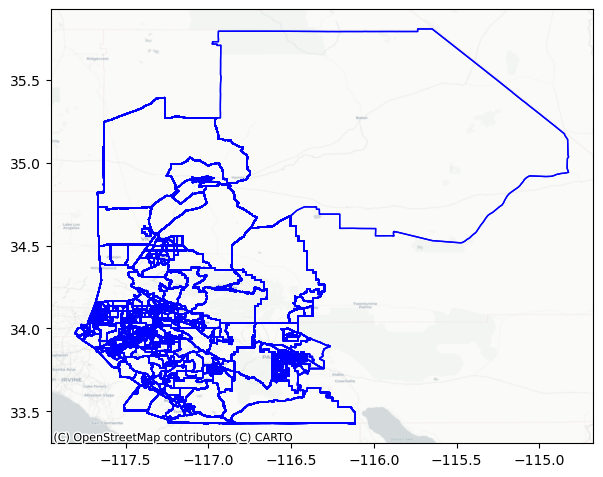

In [19]:
# final map to check that things make sense
parcel_data=parcel_data.set_geometry('geometry_census')
fig, ax = plt.subplots(figsize=(7,7))
parcel_data.sample(frac=0.01).plot(ax=ax,color='none',edgecolor='blue')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

In [20]:
parcel_data.to_csv('all_data_joined_2010.csv')